# Apprentissage d'un modèle de segmentation d'images

## Introduction

Dans cette partie, nous allons mettre en oeuvre un modèle de segmentation d'images sur un dataset particulier. Contrairement à la partie sur les modèles fondations, nous allons désormais effectuer l'ensemble de l'apprentissage ainsi que la prédiction, et l'évaluation du modèle.

## Objectifs

- Mettre en oeuvre un modèle de segmentation d'images
- Comprendre les spécificités de l'apprentissage de modèles de segmentation
- Comprendre les métriques d'évaluation des modèles de segmentation



## Les Données

Pour pouvoir effectuer l'apprentissage d'un modèle, il faut avoir accès à un jeu de données étiquetés. Pour ce faire, nous allons utiliser le [dataset emps](https://github.com/by256/emps) composé de 465 images de microscope. 

![emps.png](./assets/images/emps.png)  

Les images, ainsi que les segmentations effectuées sont disponibles dans le répertoire `data/emps`. Les images sont stockées dans le répertoire `data/emps/images` et les masques de segmentation dans le répertoire `data/emps/masks`. Les images sont au format `png` et les masques de segmentation sont au format `npy`.

Les masques de segmentation identifie non seulement le premier plan de l'arrière plan, mais également les différentes régions. Chaque région est identifiée par un entier différent. 


In [1]:
# Chargement des images et des masques
import os
input_dir = "emps/emps-main/images/"
target_dir = "emps/emps-main/segmaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".png")]
)

target_paths = sorted(
    [os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")]
)

2024-09-22 15:24:07.126460: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 15:24:07.126876: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 15:24:07.128538: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 15:24:07.134209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 15:24:07.145312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

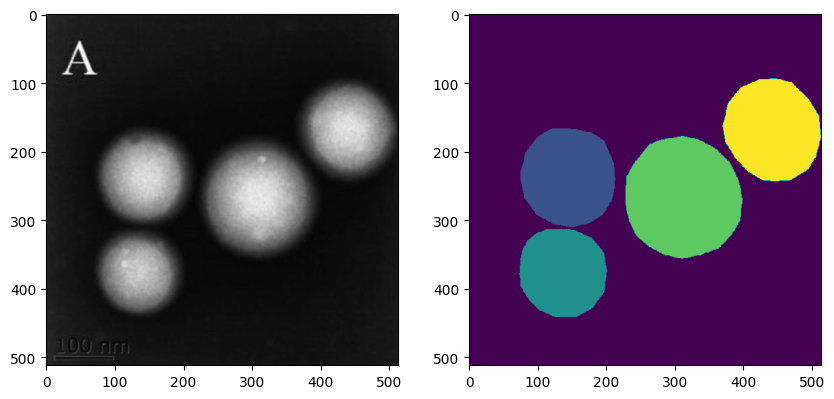

In [2]:
# visualisation des images et des masques
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

idx_image = 9

img = img_to_array(load_img(input_img_paths[idx_image], color_mode="grayscale"))
mask = img_to_array(load_img(target_paths[idx_image], color_mode="grayscale"))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap="gray")
axes[1].imshow(mask)


## Préparation des données

Afin de pouvoir à la fois apprendre et évaluer notre modèle, nous allons devoir séparer notre jeu de données en deux parties : une partie pour l'apprentissage et une partie pour l'évaluation. Pour ce faire, nous pouvons utiliser la fonction `train_test_split` de la librairie `scikit-learn`. 

Afin que notre modèle puisse apprendre, nous allons devoir effectuer un certain nombre de transformations sur les images. En effet, les images sont de taille différentes, et il est nécessaire de les redimensionner pour que le modèle puisse les traiter. De plus, il est nécessaire de normaliser les images pour que les valeurs des pixels soient comprises entre 0 et 1. Concernant les masques, nous allons simplement nous focaliser sur la séparation du premier plan de l'arrière plan.

In [3]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

# definition de la taille des images
img_size = (128,128)
# le nombre d'images au total
nums_imgs = len(input_img_paths)

def path_to_input_image(path):
    """Chargement d'une image et redimensionnement en 128x128"""
    return img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))

def path_to_target(path):
    """Chargement d'un masque et redimensionnement en 128x128. Tous les premiers plan sont affectés à la même valeur
    """
    img = img_to_array(load_img(path, 
                                target_size=img_size, 
                                color_mode="grayscale"))
    img[img > 0] = 1
    img = img.astype(np.uint8)
    return img

# initalisation des images et des masques
input_imgs = np.zeros((nums_imgs,) + img_size +(1,), dtype="float32")
masks = np.zeros((nums_imgs,) + img_size +(1,) , dtype="uint8")

# conversion des images et des masques
for i in range(nums_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    masks[i] = path_to_target(target_paths[i])

# division des données en données d'entrainement et de validation
train_input_imgs, val_input_imgs, train_targets, val_targets = train_test_split(input_imgs, masks, test_size=100, random_state=42)


print(f"La taille de l'ensemble d'entrainement est {len(train_input_imgs)}")
print(f"La taille de l'ensemble de validation est {len(val_input_imgs)}")


La taille de l'ensemble d'entrainement est 365
La taille de l'ensemble de validation est 100


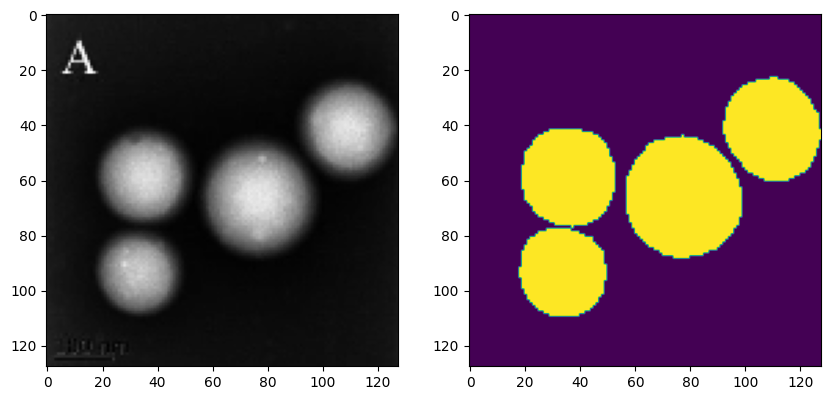

In [4]:
# les images sont en 128x128
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
img = input_imgs[idx_image]
mask = masks[idx_image]
axes[0].imshow(img, cmap="gray")
axes[1].imshow(mask)


## Mise en oeuvre du modèle

Maintenant que les données sont prêtes, nous allons pouvoir mettre en oeuvre notre modèle. Pour ce faire, nous allons utiliser un modèle de segmentation basé sur un CNN. Plus précisément, nous allons utiliser un modèle U-Net.

![ae.svg](./assets/images/ae.svg)

Le modèle U-Net est un modèle de segmentation d'images très populaire. Il est composé de deux parties : une partie de contraction et une partie d'expansion. La partie de contraction est composée de couches de convolution et de pooling, tandis que la partie d'expansion est composée de couches de convolution et de upsampling.


Pour l'implémentation, nous allons utiliser la librairie `tensorflow` et plus particulièrement le module `keras`. 

In [5]:
from tensorflow import keras 
from tensorflow.keras import layers
  
def get_model(img_size):
    inputs = keras.Input(shape=img_size + (1,))
    x = layers.Rescaling(1./255)(inputs)
    
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)  
   
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    
    outputs =  layers.Conv2D(1, 1, activation='sigmoid', padding="same")(x) 
    
    model = keras.Model(inputs, outputs)
    return model
  
model = get_model(img_size=img_size)


### Exploration du modèle

Pour commencer, nous allons explorer le modèle U-Net. Pour ce faire, nous allons utiliser la fonction `plot_model` de `keras`.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,961 (2.54 MB)

 Trainable params: 664,961 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

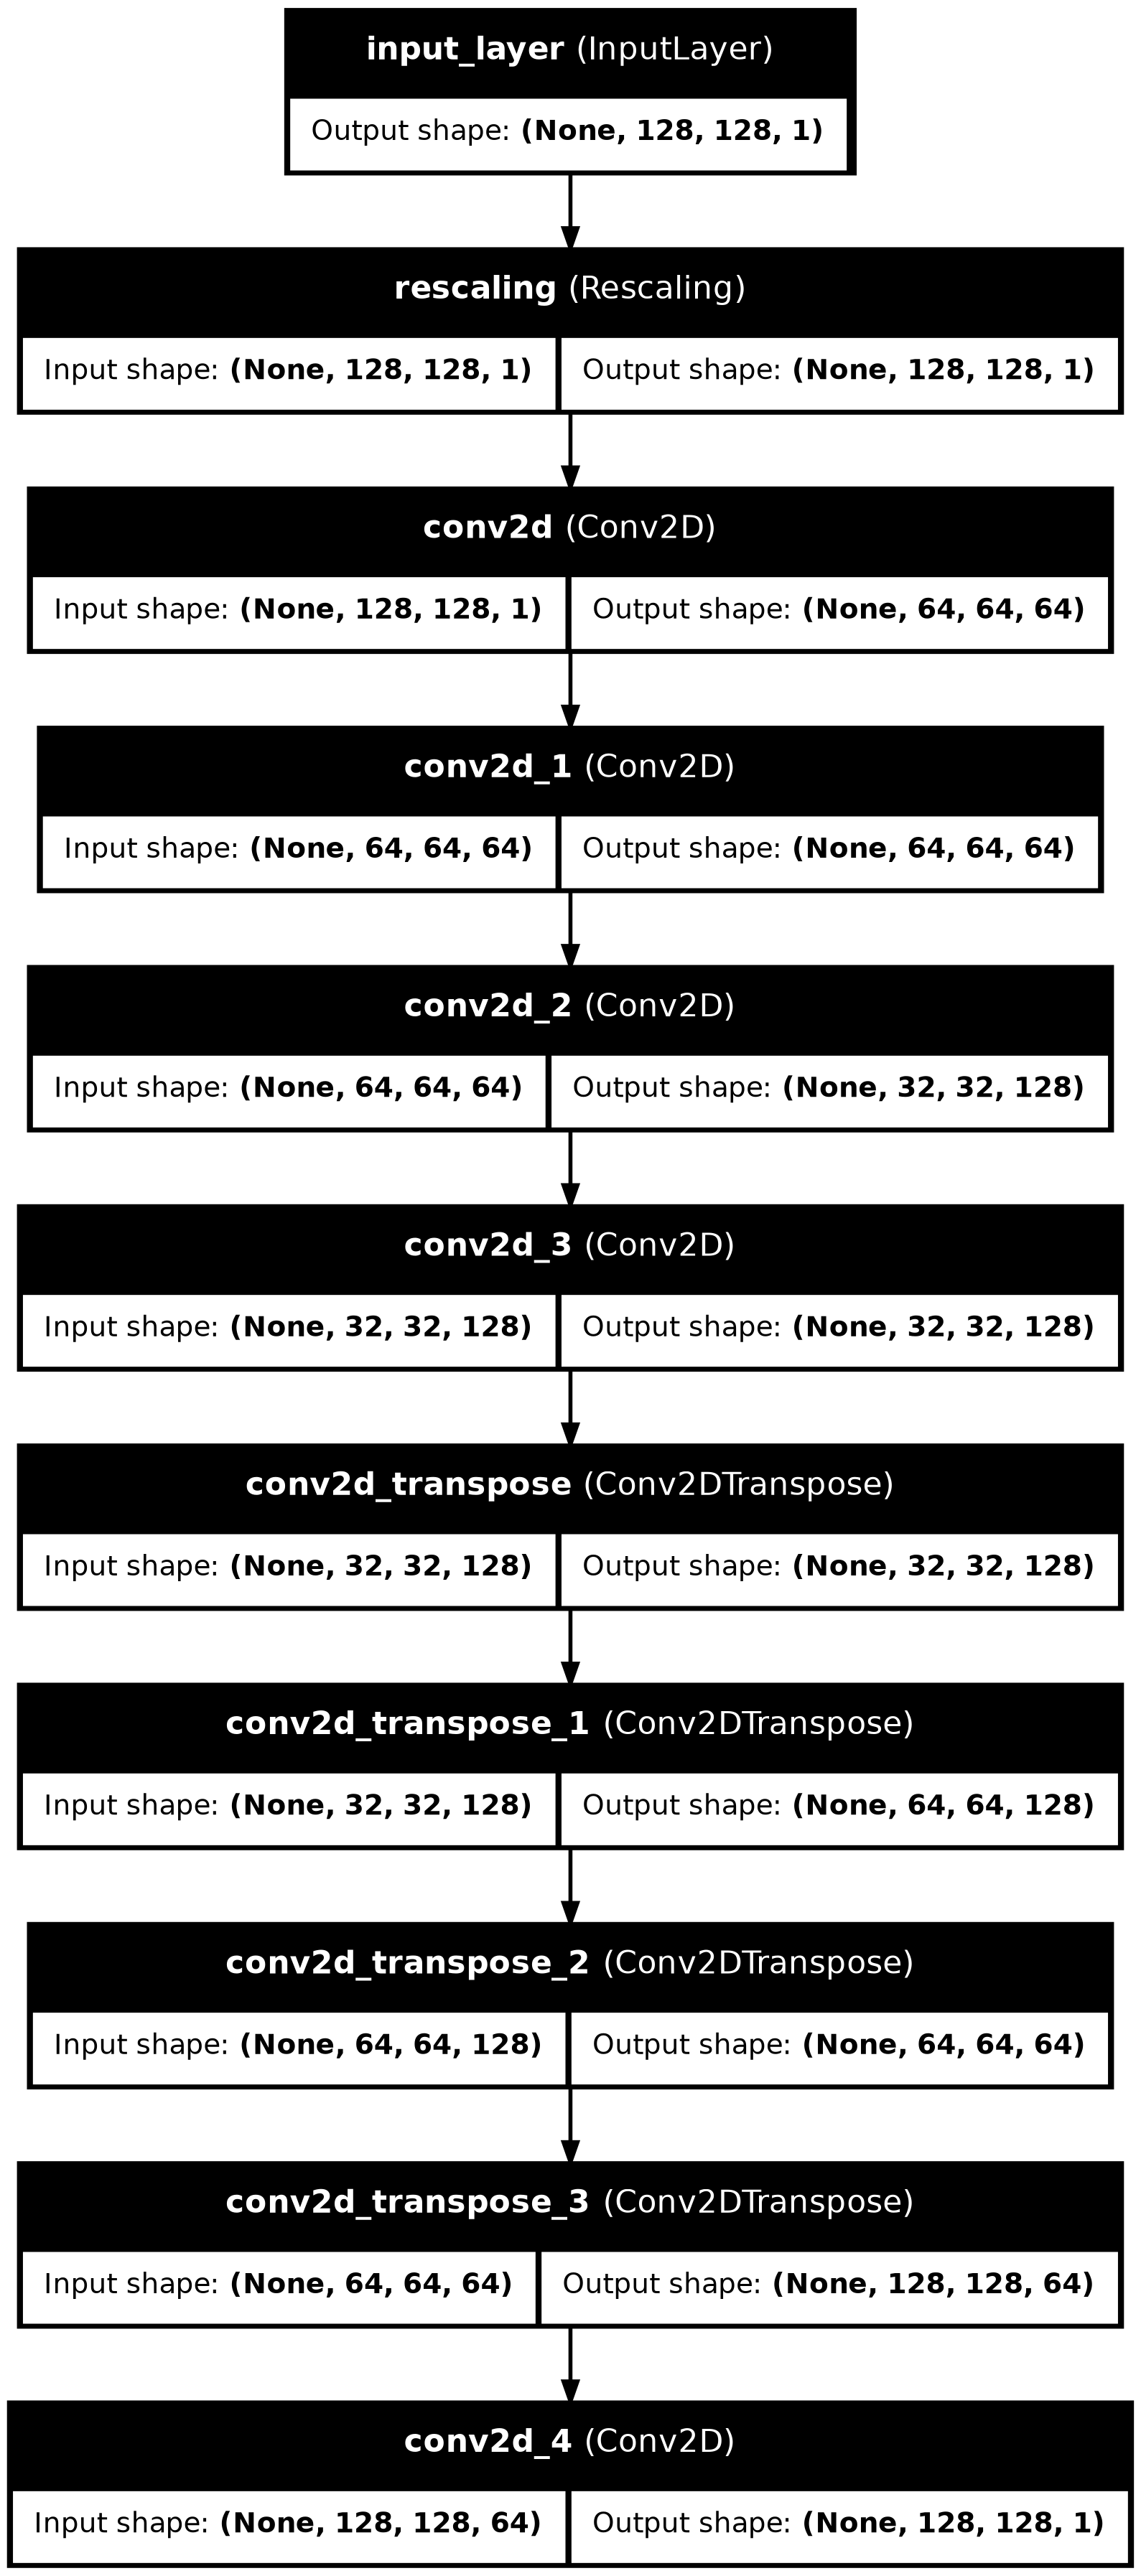

In [6]:
from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

## Apprentissage

Pour l'apprentissage, nous allons utiliser l'ensemble d'entrainement. Avant cela, nous allons devoir définir un certain nombre d'hyperparamètres. L'optimiseur, la fonction de coût, le nombre d'époques, la taille du batch, etc.

Pour l'optimiseur, nous allons utiliser l'optimiseur Adam. Cet optimiseur est celui généralement utilisé pour la plupart des réseaux de neurones.

Pour la fonction de coût, il nous faut pénaliser les cas où la valeur continue prédite est très éloignée de la valeur binaire réelle. Pour cela, nous allons utiliser une fonction de coût `binary_crossentropy`. Ces deux choix sont à renseigner dans la méthode `compile` de notre modèle.

Enfin, nous allons entrainer notre modèle en utilisant la méthode `fit` de notre modèle. Nous devons spécifier les données d'entrainement, le nombre d'époques, la taille du batch, ainsi que les données utilisées pour évaluer notre modèle sur des données inconnues.

Afin également de suivre l'évolution de notre modèle, nous allons utiliser un `callback` qui nous permettra d'enregistrer les poids de notre meilleur modèle selon la performance sur l'ensemble de validation.

Une fois tous ces paramètres renseignés, nous pouvons lancer l'apprentissage de notre modèle. Attention, selon la configuration de votre machine, celui ci peut durer jusqu'à 30 minutes pour 100 epochs.

In [7]:
%timeit

import tensorflow as tf
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy') 

callbacks = [
    keras.callbacks.ModelCheckpoint("emps_coria.keras", save_best_only=True)
    ]   

history = model.fit(train_input_imgs, train_targets, 
                    epochs=100, callbacks=callbacks, 
                    batch_size=32, validation_data=(val_input_imgs, val_targets))


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 888ms/step - loss: 0.6708 - val_loss: 0.6564
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 836ms/step - loss: 0.6338 - val_loss: 0.6503
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 864ms/step - loss: 0.6099 - val_loss: 0.6409
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 874ms/step - loss: 0.6118 - val_loss: 0.6437
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 928ms/step - loss: 0.6108 - val_loss: 0.6433
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.6044 - val_loss: 0.6276
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.5780 - val_loss: 0.6439
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.6140 - val_loss: 0.6434
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.6008 - val_loss: 0.6057
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.5771 - val_loss: 0.6126
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.5576 - val_loss: 0.6383
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/s

## Analyse des résultats

Pour analyser si tout s'est bien passé, nous allons observer les courbes d'apprentissage. Dans un premier temps, nous allons afficher la courbe de la fonction de coût sur l'ensemble d'apprentissage en fonction du nombre d'epochs. Puis, nous allons afficher la courbe de la fonction de coût sur l'ensemble de validation en fonction du nombre d'epochs.

Pour cela, explorer la variable `history` de l'objet retourné par la méthode `fit`. Utilisez la librairie `matplotlib` pour afficher les courbes via la fonction `plot`.

Le phénomène d'overfitting apparait lorsque la courbe de la fonction de coût sur l'ensemble de validation commence à augmenter alors que la courbe de la fonction de coût sur l'ensemble d'apprentissage continue de diminuer. Quel est alors le modèle optimal ? 


In [ ]:
epochs = range(1,len(history.history["loss"])+1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "g", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()



## Evaluation du modèle

Afin d'évaluer notre modèle, nous allons d'abord sélectionner le modèle qui a obtenu les meilleures performances sur l'ensemble de validation.

Ensuite, nous allons utiliser l'ensemble de test. Pour cela, nous allons devoir prédire les masques de segmentation pour quelques images de l'ensemble de test. Ensuite, nous allons comparer les masques prédits avec les masques réels. Pour cela, nous allons utiliser différentes métriques d'évaluation.

In [ ]:
# chargement du meilleur modele  
print(f"Le meilleur modèle est atteint pour l'epoch {np.argmin(val_loss)}")
model = keras.models.load_model("emps_coria.keras")


## Évaluation qualitative

Pour l'évaluation qualitative, nous allons afficher 9 images de l'ensemble de test, avec les masques prédits correspondants. 

Pour cela, nous allons utiliser la librairie `matplotlib`. 

In [ ]:
# on prend 9 images au hasard parmi la val pour affichage 
import numpy as np
indexes = np.random.randint(0,len(val_input_imgs), 9)
print(indexes)

In [ ]:
from tensorflow.keras.utils import array_to_img

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # image à tester
    test_img = val_input_imgs[indexes[i]]
    # affichage de l'image
    ax.imshow(array_to_img(test_img),cmap="gray")
    ax.axis("off")
    # calcul du masque prédit
    pred = model(np.expand_dims(test_img, 0))[0] #mini batch de taille 1
    #conversion en image
    mask = array_to_img(pred)
    ax.imshow(mask, alpha=0.25, cmap="viridis")

## Evaluation quantitative

Pour évaluer la qualité de notre modèle, nous allons utiliser différentes métriques d'évaluation. À la différence de l'évaluation qualitative effectuée précédemment, l'évaluation quantitative permet de mesurer la performance du modèle de manière plus précise. Pour cela, nous pouvons définir ce qui correspond à une bonne segmentation. 

La première manière, la plus simpliste, est de calculer la précision de classification en comparant les masques prédits avec les masques réels pixel par pixel. Si les deux masques sont identiques, alors la prédiction est parfaite. Cependant, cette méthode n'est pas très robuste. En effet, si un pixel est décalé, alors la prédiction sera considérée comme fausse. 

$$
Accuracy = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}_{\hat{y}_i = y_i}
$$


Une deuxième manière de mesurer la performance est d'utiliser l'indice de Jaccard, appelé également IOU pour Intersection Over Union. Comme son nom l'indique, cette mesure est définie comme le rapport entre l'intersection et l'union du masque prédit et du masque correspondant à la vérité terrain. Plus l'indice de Jaccard est proche de 1, plus la prédiction est bonne.

$$
IOU = \frac{|X \cap Y|}{|X \cup Y|}
$$

Enfin, une troisième mesure est le Dice Score. Cette mesure, similaire à l'indice de Jaccard,  est également basée sur l'intersection et l'union des masques prédits et réels. Plus le Dice Score est proche de 1, plus la prédiction est bonne. Le Dice Score est défini comme suit :

$$
Dice = \frac{2 \times |X \cap Y|}{|X| + |Y|}
$$

Afin de mettre en oeuvre ces indices, il faut d'abord déterminer, pour chaque pixel, si il appartient au premier plan ou à l'arrière plan. Pour cela, nous allons utiliser un seuil. Si la probabilité prédite est supérieure à ce seuil, alors le pixel appartient au premier plan, sinon il appartient à l'arrière plan. Communément, le seuil est fixé à 0,5.




In [ ]:
# evaluation du modele
# intersection over union
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# dice score
def dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice = 2 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

# accuracy
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# evaluation du modèle
preds = model.val_input_imgs
iou = []
dice = []
acc = []

for i in range(len(val_input_imgs)):
    iou.append(iou_score(val_targets[i], preds[i] > 0.5))
    dice.append(dice_score(val_targets[i], preds[i] > 0.5))
    acc.append(accuracy(val_targets[i], preds[i] > 0.5))

print(f"iou: {np.mean(iou)}")
print(f"dice: {np.mean(dice)}")
print(f"accuracy: {np.mean(acc)}")


